In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np

In [3]:
import matplotlib.pyplot as plt

# Dengue Challenge

Goal : predict the number of dengue cases per week based on various environmental variables records for two cities.

## 1. Loading

In [4]:
train_labels = pd.read_csv('./data/dengue_labels_train.csv')
train_data = pd.read_csv('./data/dengue_features_train.csv')
test_data = pd.read_csv('./data/dengue_features_test.csv')

|    Name                               | Source    |Description                        | Type    | Range  |
|---------------------------------------|-----------|-----------------------------------|---------|--------|
|`city`                                 | label     |city where data were recorded      |`str`    |`sj, iq`|
|`year`                                 | label     |year of record                     |`int`    |        |
|`weekofyear`                           | label     |week number                        |`int`    |        |
|`total_cases`                          | label     |number of cases                    |`int`    |        |
|`week_start_date`                      | label     |start of the week                  |`str`    |        |
|`ndvi_ne`                              | satellite |vegetation                         |`float64`|        |
|`ndvi_nw`                              | satellite |vegetation                         |`float64`|        |
|`ndvi_se`                              | satellite |vegetation                         |`float64`|        |
|`ndvi_sw`                              | satellite |vegetation                         |`float64`|        |
|`precipitation_amt_mm`                 | satellite |precipitation (mm)                 |`float64`|        |
|`reanalysis_air_temp_k`                | noaa      |air temperature (kelvin)           |`float64`|        |
|`reanalysis_avg_temp_k`                | noaa      |air temperature (kelvin)           |`float64`|        |
|`reanalysis_dew_point_temp_k`          | noaa      |dew point temperature (kelvin)     |`float64`|        |
|`reanalysis_max_air_temp_k`            | noaa      |max air temperature (kelvin)       |`float64`|        |
|`reanalysis_min_air_temp_k`            | noaa      |min air temperature (kelvin)       |`float64`|        |
|`reanalysis_precip_amt_kg_per_m2`      | noaa      |precipitation (kg/m2)              |`float64`|        |
|`reanalysis_relative_humidity_percent` | noaa      |humidity (%)                       |`float64`|        |
|`reanalysis_sat_precip_amt_mm`         | noaa      |precipitation (mm)                 |`float64`|        |
|`reanalysis_specific_humidity_g_per_kg`| noaa      |humidity (g/kg)                    |`float64`|        |
|`reanalysis_tdtr_k`                    | noaa      |diurnal temperature range (kelvin) |`float64`|        |
|`station_avg_temp_c`                   | local     |average temperature (celcius)      |`float64`|        |
|`station_diur_temp_rng_c`              | local     |diurnal temperature range (celcius)|`float64`|        |
|`station_max_temp_c`                   | local     |max temperature (celcius)          |`float64`|        |
|`station_min_temp_c`                   | local     |min temperature (celcius)          |`float64`|        |
|`station_precip_mm`                    | local     |precipitations (mm)                |`float64`|        |

## 2. Cleaning

### Formatting

In [5]:
# add labels to data
train_data['total_cases'] = train_labels['total_cases'] 

In [6]:
# index to datetime
train_data.index = pd.to_datetime(train_data['week_start_date'])

In [7]:
# drop irrelevant variables
train_data = train_data.drop(['year', 'weekofyear', 'week_start_date'], axis=1)

In [8]:
# drop index name
train_data.index.name = None

In [9]:
# convert format (celsius to kelvin)
train_data['station_avg_temp_c'] += 273.15
train_data['station_diur_temp_rng_c'] += 273.15
train_data['station_max_temp_c'] += 273.15
train_data['station_min_temp_c'] += 273.15

### Missing data

In [10]:
# we consider missing values city-wise
train_data_sj = train_data[train_data['city'] == 'sj']
train_data_iq = train_data[train_data['city'] == 'iq']

In [11]:
# % of missing values per city and feature
# print(train_data_sj.isnull().sum() / len(train_data_sj) * 100)
# print(train_data_iq.isnull().sum() / len(train_data_iq) * 100)

In [12]:
train_data_sj = train_data_sj.interpolate(method='time')
train_data_iq = train_data_iq.interpolate(method='time')
train_data = pd.concat([train_data_sj, train_data_iq]).sort_index()

### Correlation Matrix

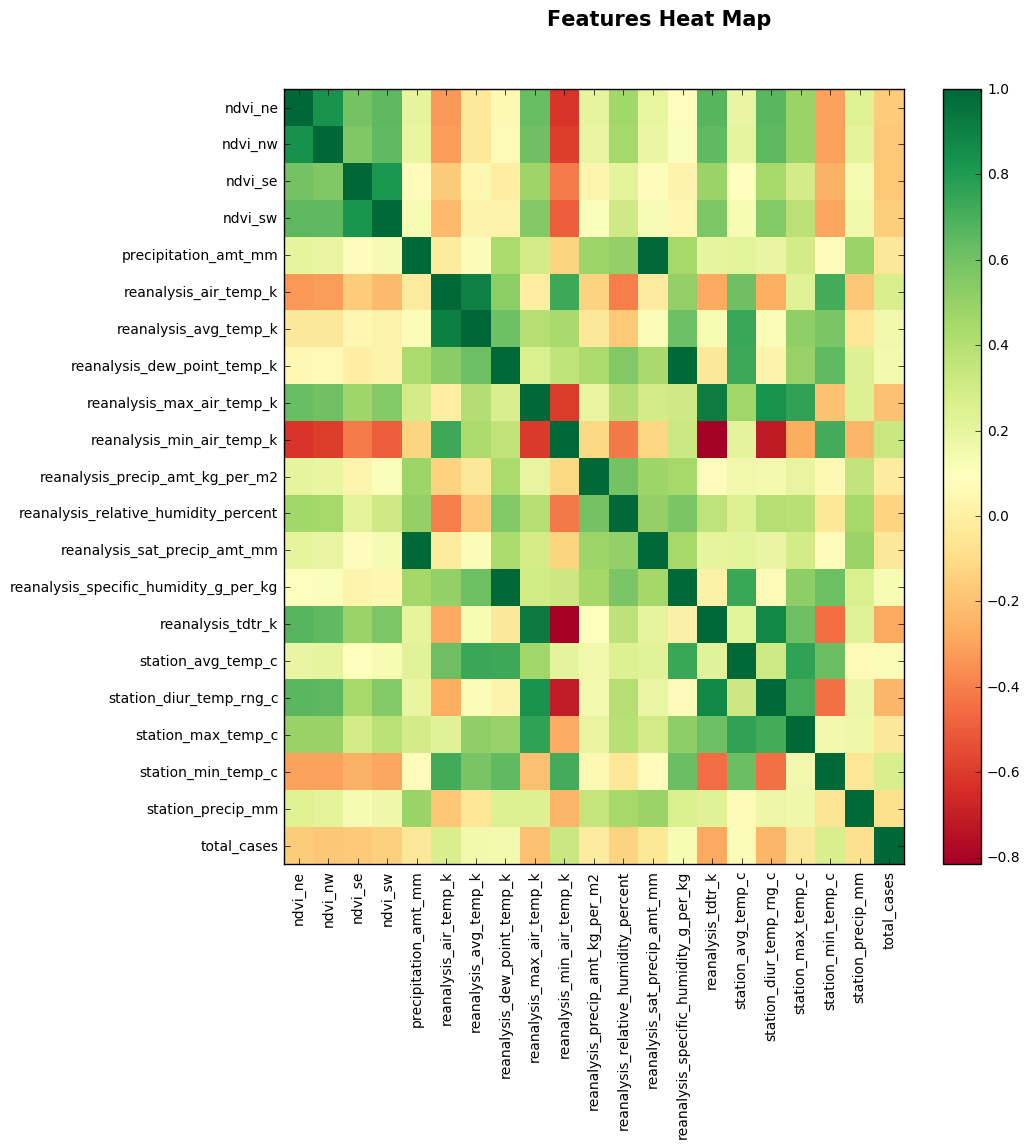

In [13]:
corr = train_data.corr()
plt.figure(figsize=(10, 10))
plt.imshow(corr, cmap='RdYlGn', interpolation='none', aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation='vertical')
plt.yticks(range(len(corr)), corr.columns);
plt.suptitle('Features Heat Map', fontsize=15, fontweight='bold')
plt.show()

### Merge

In [14]:
# no huge difference between these three
train_data['precipitations'] = train_data[['precipitation_amt_mm', 
                                           'reanalysis_sat_precip_amt_mm', 
                                           'station_precip_mm']].mean(axis=1)
# drop duplicates
train_data = train_data.drop(['precipitation_amt_mm', 
                              'reanalysis_sat_precip_amt_mm', 
                              'station_precip_mm'], axis=1)

In [15]:
# merge temperature measurements
train_data['temperature'] = train_data[['reanalysis_air_temp_k', 
                                        'reanalysis_avg_temp_k', 
                                        'station_avg_temp_c']].mean(axis=1)

# drop duplicates
train_data = train_data.drop(['reanalysis_air_temp_k', 
                              'reanalysis_avg_temp_k', 
                              'station_avg_temp_c'], axis=1)

In [16]:
# merge max and min temperature
train_data['max_temperature'] = train_data[['reanalysis_max_air_temp_k',
                                            'station_max_temp_c']].mean(axis=1)
train_data['min_temperature'] = train_data[['reanalysis_min_air_temp_k',
                                            'station_min_temp_c']].mean(axis=1)
# drop duplicates
train_data = train_data.drop(['reanalysis_max_air_temp_k',
                              'station_max_temp_c',
                              'reanalysis_min_air_temp_k',
                              'station_min_temp_c'], axis=1)

In [17]:
# drop dew data (duplicate from humidity)
train_data = train_data.drop(['reanalysis_dew_point_temp_k'], axis=1)

## 3. Summary

In [18]:
train_data.head()

,city,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_diur_temp_rng_c,total_cases,precipitations,temperature,max_temperature,min_temperature
1990-04-30,sj,0.122600,0.103725,0.198483,0.177617,32.00,73.365714,14.012857,2.628571,280.050000,4,13.613333,297.969524,301.175,294.525
1990-05-07,sj,0.169900,0.142175,0.162357,0.155486,17.94,77.368571,15.372857,2.371429,279.521429,5,18.080000,298.839524,302.875,295.875
1990-05-14,sj,0.032250,0.172967,0.157200,0.170843,26.10,82.052857,16.848571,2.300000,279.635714,4,36.826667,299.174762,302.925,296.625
1990-05-21,sj,0.128633,0.245067,0.227557,0.235886,13.90,80.337143,16.672857,2.428571,279.921429,3,11.573333,299.612381,303.925,296.725
1990-05-28,sj,0.196200,0.262200,0.251200,0.247340,12.20,80.460000,17.210000,3.014286,282.521429,6,6.946667,300.425238,305.025,297.275
